# Table of Contents
* [Intro](#Intro)
* [Interval Stats](#Interval-Stats)
* [Basic length stats](#Basic-length-stats)
	* [By Sender](#By-Sender)
	* [By Year and Month](#By-Year-and-Month)
	* [By Hour](#By-Hour)
	* [By Day](#By-Day)
* [Lexical Stats](#Lexical-Stats)
	* [By Sender](#By-Sender)
	* [By Year and Month](#By-Year-and-Month)
	* [By Hour](#By-Hour)
* [Emoticons Stats](#Emoticons-Stats)
* [Interactive Visualization](#Interactive-Visualization)


# Intro

This notebook explores the basic conversation stats together with their visualization.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import sys
sys.path.append(os.path.join(os.getcwd(), "src"))

import util.io as mio
from util import statsUtil
import util.plotting as mplot
from model.conversationDataframe import ConversationDataframe
from stats.iConvStats import IConvStats

sns.set_context("paper")
sns.set_style("darkgrid")

In [2]:
# filepath to your conversation file. You can use my conversations examples for testing
FILEPATH = "src/resources/unittest/test_plotting.txt"
conv = ConversationDataframe(FILEPATH)
conv.loadMessages()

# Interval Stats

In [100]:
start, end, interval = conv.stats.getIntervalStats()
days = conv.stats.getDaysWithoutMessages()
print("Conversation started: {}".format(str(start)))
print("Conversation ended: {}".format(str(end)))
print("Conversation overall duration: {}".format(interval))

percentage = (len(days)/(interval.days+1))*100
print("{:.0f} days without messages ({:.2f}% of the total days duration)".format(len(days), percentage))

Conversation started: 2014-01-30 17:58:04
Conversation ended: 2015-11-29 19:58:14
Conversation overall duration: 668 days 02:00:10
29 days without messages (4.33% of the total days duration)


# Basic Length Stats

Aggregated stats for the following metrics:
* number of messages (each messanger bubble is a separate message)
* total length of messages (in number of characters, special ones included)
* message average length (averaging total length by number of messages)

## By Sender

In [101]:
basicLengthStats = conv.stats.generateStats(IConvStats.STATS_NAME_BASICLENGTH)
basicLengthStats

,lenMsgs,numMsgs,avgLen
sender,,,
s1,49352,984,50.154472
s2,49086,1016,48.312992
total,98438,2000,49.219000


## By Year and Month

In [122]:
month_basic_stats = conv.stats.generateStatsByYearAndMonth(IConvStats.STATS_NAME_BASICLENGTH, stackStats=True)

<IPython.core.display.Javascript object>


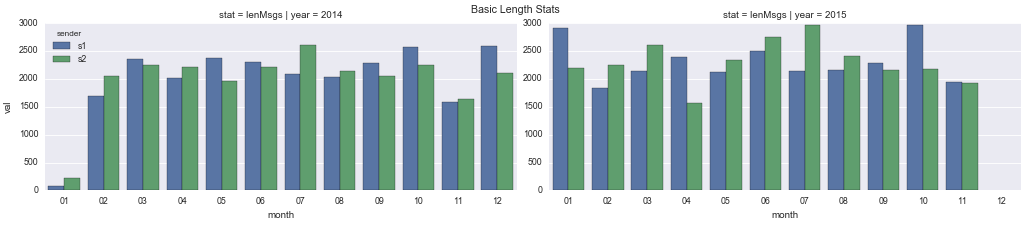

In [123]:
mplot.plotBasicLengthStatsByYearAndMonth(month_basic_stats, 
                                         targetSenders=['s1','s2'], 
                                         targetStats=['lenMsgs'],
                                        yearsToShow=None)

## By Hour

In [124]:
hours_basic_stats = conv.stats.generateStatsByHour(IConvStats.STATS_NAME_BASICLENGTH, stackStats=True)

<IPython.core.display.Javascript object>


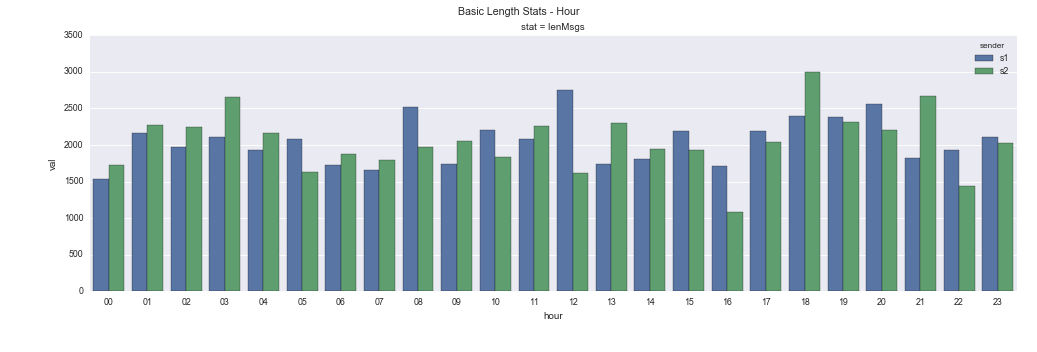

In [125]:
mplot.plotBasicLengthStatsByHour(hours_basic_stats, 
                                 targetSenders=['s1','s2'], 
                                 targetStats=['lenMsgs'])

## By Day

In [105]:
day_basic_stats = conv.stats.generateStatsByYearMonthDay(IConvStats.STATS_NAME_BASICLENGTH)

<IPython.core.display.Javascript object>


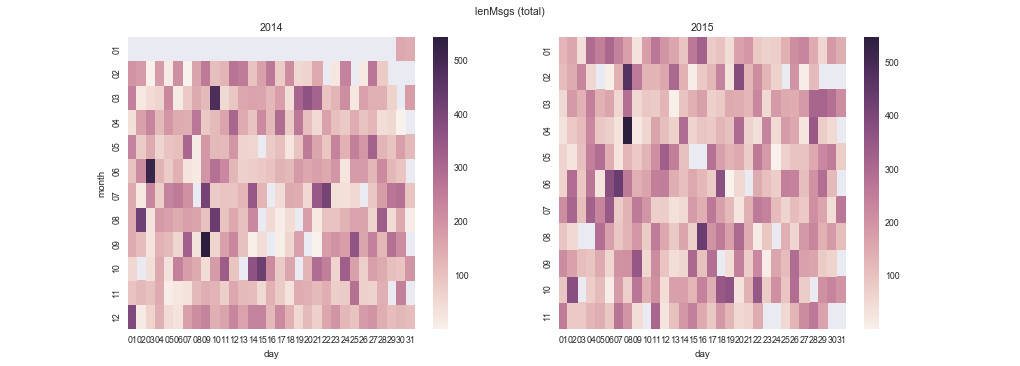

In [108]:
mplot.plotSingleBasicLengthStatHeatmap(day_basic_stats, 'lenMsgs', 'total', ['2014','2015'])

In [110]:
df = statsUtil.dateRangeTransform(day_basic_stats, {'sender':['total'], 'stat':['numMsgs']})

<IPython.core.display.Javascript object>


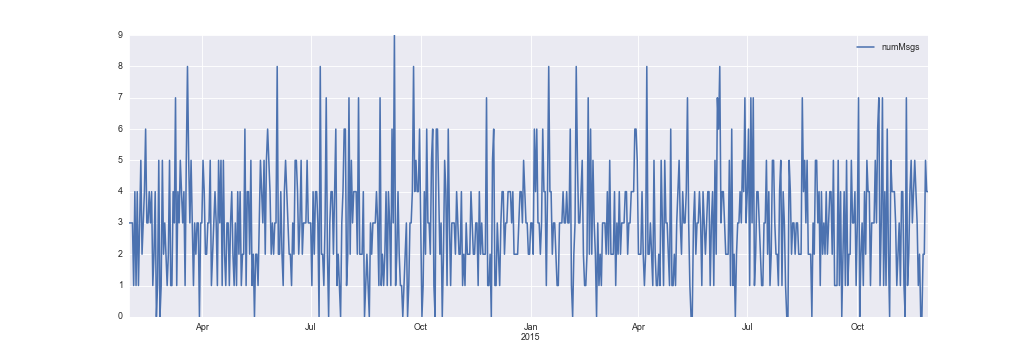

In [111]:
df.plot()

# Lexical Stats
Tokens count and vocabulary. Tokens count consider also duplicate words, while vocabulary (also called types) is the count of unique words. Lexical richness/diversity is the ratio between vocabulary and tokens count.

## By Sender

In [3]:
lexicalStats = conv.stats.generateStats(IConvStats.STATS_NAME_LEXICAL)
lexicalStats

,lexicalRichness,tokensCount,vocabularyCount
sender,,,
s1,0.290862,8853.0,2575.0
s2,0.303149,8702.0,2638.0


## By Year and Month

In [4]:
month_lexical_stats = conv.stats.generateStatsByYearAndMonth(IConvStats.STATS_NAME_LEXICAL)

<IPython.core.display.Javascript object>


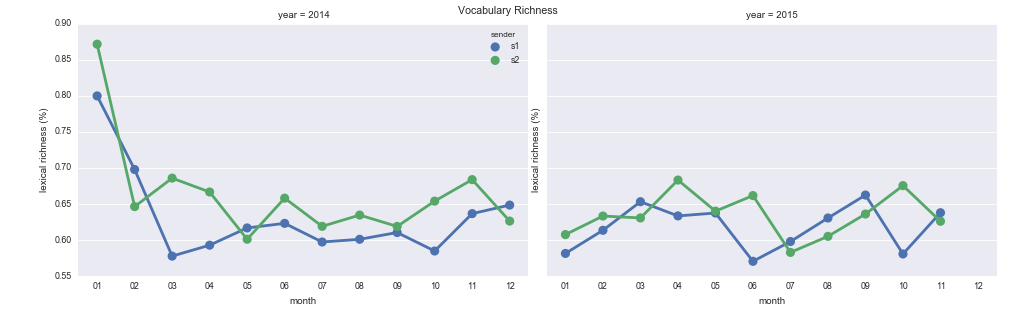

In [5]:
mplot.plotRichnessVariation(month_lexical_stats, 'month', yearsToShow=['2014', '2015'])

## By Hour

In [8]:
hour_lexical_stats = conv.stats.generateStatsByHour(IConvStats.STATS_NAME_LEXICAL, stackStats=True)

<IPython.core.display.Javascript object>


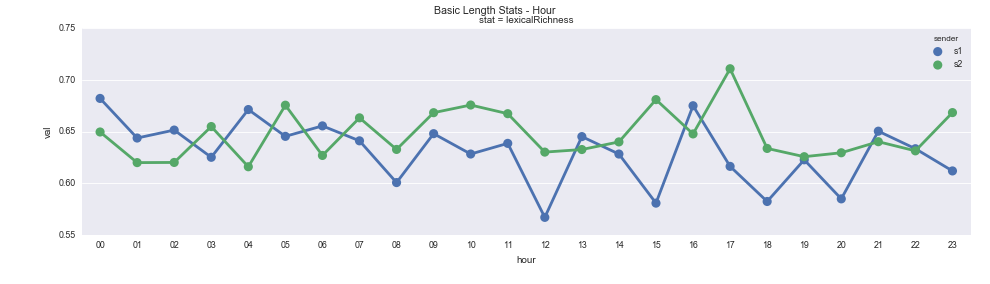

In [11]:
mplot.plotBasicLengthStatsByHour(hour_lexical_stats, targetStats=['lexicalRichness'], kind='point')

# Emoticons Stats

In [16]:
emoticons_stats = conv.stats.generateStats(IConvStats.STATS_NAME_EMOTICONS)
emoticons_stats

,numEmoticons,emoticonsRatio,lenMsgs
sender,,,
s1,58,0.001152,50335
s2,63,0.001257,50101
total,121,0.001205,100436


# Interactive Visualization [WIP]

In [88]:
from ipywidgets import interact, widgets

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

%matplotlib inline

In [64]:
hours_basic_stats = conv.stats.generateStatsByYearAndHour(IConvStats.STATS_NAME_BASICLENGTH, stackStats=True)

In [79]:
years = list(map(int, hours_basic_stats['year'].unique()))

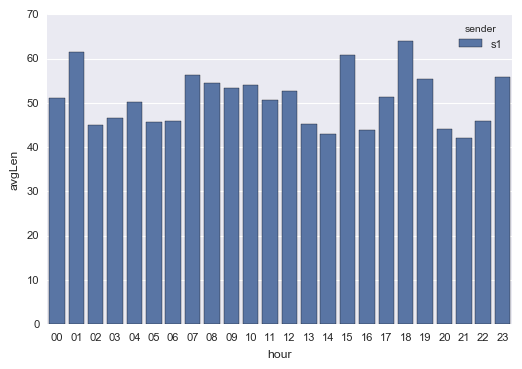

In [93]:
@interact(sender=list(map(str, hours_basic_stats['sender'].unique())), 
          stat=list(map(str, hours_basic_stats['stat'].unique())), 
          #year=list(map(str, hours_basic_stats['year'].unique())))
          year=(years[0], years[-1]))
def myplot(sender, stat, year):
    mplot.plotSingleBasicLengthStatByYearAndHour(hours_basic_stats, stat, 
                                                 yearsToShow=[str(year)],
                                                targetSenders=[sender])
    sns.plt.show()

In [73]:
class Dashboard():
    def __init__(self, data):
        self.data = data
        self.selectors = {}
        
    def create_selector(self, target_col, description):
        selector = widgets.SelectMultiple(
            options = list(map(str, self.data[target_col].unique())),
            description = description
        )
        self.selectors[target_col] = selector
        
    def get_selector_values(self, selector_key):
        return list(self.selectors[selector_key].value)
    
    def run(self, fun):
        for k, selector in self.selectors.items():
            selector.observe(fun, names='value')
            display(selector)

<IPython.core.display.Javascript object>


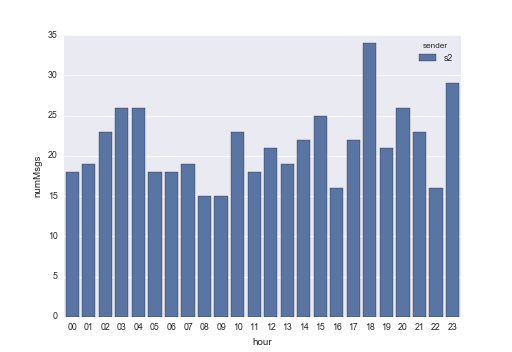

In [74]:
d = Dashboard(hours_basic_stats)
d.create_selector('year', 'Year:')
d.create_selector('sender', 'Sender:')

def my_plot(x):
    sns.plt.clf()
    mplot.plotSingleBasicLengthStatByYearAndHour(hours_basic_stats, 'lenMsgs', 
                                                 yearsToShow=d.get_selector_values('year'),
                                                targetSenders=d.get_selector_values('sender'))

d.run(my_plot)